## Part A: Subreddit Prediction ##

# Data Preparation

In [1]:
subreddit_train = "coursework_subreddit_train.json"
subreddit_validation = "coursework_subreddit_validation.json"
subreddit_test = "coursework_subreddit_test.json"

!gsutil cp gs://textasdata/coursework/coursework_subreddit_train2020.json $subreddit_train 
!gsutil cp gs://textasdata/coursework/coursework_subreddit_validation2020.json $subreddit_validation 
!gsutil cp gs://textasdata/coursework/coursework_subreddit_test.json  $subreddit_test

Copying gs://textasdata/coursework/coursework_subreddit_train2020.json...
/ [1 files][  8.0 MiB/  8.0 MiB]                                                
Operation completed over 1 objects/8.0 MiB.                                      
Copying gs://textasdata/coursework/coursework_subreddit_validation2020.json...
/ [1 files][  2.1 MiB/  2.1 MiB]                                                
Operation completed over 1 objects/2.1 MiB.                                      
Copying gs://textasdata/coursework/coursework_subreddit_test.json...
/ [1 files][  2.7 MiB/  2.7 MiB]                                                
Operation completed over 1 objects/2.7 MiB.                                      


In [0]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import pandas as pd
import json
import numpy as np
train_threads = pd.read_json(path_or_buf=subreddit_train, lines=True)


def get_thread_fields(t_thread):
  posts_tmp = list()
  i = 0
  for post in np.array(t_thread['posts']):
    title = t_thread['title'][i]
    i += 1
    body_list = []
    author_list = []
    for p in post:
      body_list.append(p.get('body'))
      author_list.append(p.get('author'))
    posts_tmp.append((title,str(author_list),str(body_list)))
  # Create the posts data frame.  
  labels = ['title', 'author', 'body']
  temp_frame = pd.DataFrame(posts_tmp, columns=labels)
  return temp_frame

train_frame = get_thread_fields(train_threads)
train_frame.head(10)



,title,author,body
0,My Friend/Crush [22/F] acting weird after I [2...,"['Melodrama_', 'Melodrama_', 'TreatYoSelves', ...","[""It's a sad realization, isn't it?"", ""I told ..."
1,"Have you ever gotten revenge on someone, and t...","[None, 'HIGH-AS-FUCK', 'Hobbs54', 'Oniknight']","[""Browsing Reddit, I've seen numerous posts wh..."
2,"Despite the English Definition, Is weed Someho...","['IGOA2BBYKEEPINGITG', 'AnxiousHerb', 'kslushe...","['Some poster is telling me ""you\'re a dense f..."
3,What's a good television show in Latin America...,"['mrspence', None, 'Ted_Denslow', 'ChewableTit...",['I like shows like Dexter and Walking Dead. ...
4,"ELI5: Legally, does every crime have to have a...","['nikiverse', 'AgoraiosBum', 'nikiverse', 'Ago...","['Is a ""motive"" necessary to prosecute someone..."
5,"Battleship (movie, 2012) - Bestest Freshest ta...","['Oh_hai_o', 'humble_narcissist', 'keithb', 'h...",['Not sure if being funny or seriously liked? ...
6,What are some good apps to have on a iPhone??,"['spartacus24', 'Missing_nosleep', 'spartacus2...","[""I'm getting bored of the apps I have on my i..."
7,"Now that Leo has won Oscars, who would we meme...","['flexice', 'Sabedoria', 'Lampburglar', 'KingO...","['', '""Why doesn\'t he have more"" obviously.',..."
8,Toph and Katara (the last airbender) VS Sloth ...,"['rie9shock', 'robcap', 'vadergeek', 'robcap',...","['', ""Hmm. I think Sloth.\n\nToph and Katara d..."
9,What is your current ringtone/sms sound?,"['gfragozo', None, None, 'Jaycatt', '_Goose_',...",['My ringtone is Joker from Mass Effect 2 sayi...


In [0]:
validation_threads = pd.read_json(path_or_buf=subreddit_validation, lines=True)
validation_frame = get_thread_fields(validation_threads)

In [0]:
test_threads = pd.read_json(path_or_buf=subreddit_test, lines=True)
test_frame = get_thread_fields(test_threads)

In [6]:
subreddit_counts = train_threads['subreddit'].value_counts()
print(subreddit_counts.describe())
top_subbreddits = subreddit_counts.nlargest(20)
top_subbreddits_list = top_subbreddits.index.tolist()
print(top_subbreddits)

count     20.000000
mean      58.200000
std       60.248258
min       20.000000
25%       28.750000
50%       38.500000
75%       49.500000
max      276.000000
Name: subreddit, dtype: float64
askreddit               276
leagueoflegends         157
buildapc                103
explainlikeimfive        60
gaming                   51
trees                    49
techsupport              48
pcmasterrace             47
electronic_cigarette     46
relationships            42
tipofmytongue            35
summonerschool           33
jailbreak                31
hearthstone              30
whowouldwin              29
atheism                  28
personalfinance          27
reddit.com               27
movies                   25
starcraft                20
Name: subreddit, dtype: int64


In [0]:
train_features = train_frame
validation_features = validation_frame
test_features = test_frame
train_labels = train_threads['subreddit']
validation_labels = validation_threads['subreddit']
test_labels = test_threads['subreddit']

In [8]:
import spacy

nlp =spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

('parser', <spacy.pipeline.pipes.DependencyParser at 0x7ff8581d6288>)

In [0]:
#@Tokenize
def spacy_tokenize(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
    tokens.append(token)
  return tokens

#@Normalize
def normalize(tokens):
  normalized_tokens = list()
  for token in tokens:
    normalized = token.text.lower().strip()
    if ((token.is_alpha or token.is_digit)):
      normalized_tokens.append(normalized)
  return normalized_tokens
  return normalized_tokens

#@Tokenize and normalize
def tokenize_normalize(string):
  return normalize(spacy_tokenize(string))

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='macro') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  # Specify three digits instead of the default two.
  print(classification_report(predictions, true_labels, digits=3))
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions)) # Note the order here is true, predicted, odd.
  return classification_report(predictions, true_labels, digits=3,output_dict=True)

## Q1

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]
class MySelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return np.array(data_dict[self.key]).reshape(len(data_dict), 1)


In [11]:
DummyClassifier_feature_union = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('one-hot', CountVectorizer(binary=True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('one-hot', CountVectorizer(binary=True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('one-hot', CountVectorizer(binary=True)), 
              ])),
        ])
        ),
        ('dummy', DummyClassifier(strategy='most_frequent'))
    ])
DummyClassifier_feature_union.fit(train_features,train_labels)
#_=evaluation_summary("DummyClassifier Union Pipeline", DummyClassifier_feature_union.predict(validation_features), validation_labels) 
_=evaluation_summary("DummyClassifier Union Pipeline", DummyClassifier_feature_union.predict(test_features), test_labels) 

Evaluation for: DummyClassifier Union Pipeline
Classifier 'DummyClassifier Union Pipeline' has Acc=0.230 P=0.050 R=0.012 F1=0.019
                      precision    recall  f1-score   support

           askreddit      1.000     0.230     0.374       365
             atheism      0.000     0.000     0.000         0
            buildapc      0.000     0.000     0.000         0
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.000     0.000     0.000         0
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
 

In [12]:
DummyClassifier2_feature_union = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
        ])
        ),
        ('dummy2', DummyClassifier(strategy='stratified'))
    ])
DummyClassifier2_feature_union.fit(train_features,train_labels)
#_ =evaluation_summary("DummyClassifier2 Union Pipeline", DummyClassifier2_feature_union.predict(validation_features), validation_labels) 
_=evaluation_summary("DummyClassifier2 Union Pipeline", DummyClassifier2_feature_union.predict(test_features), test_labels) 

Evaluation for: DummyClassifier2 Union Pipeline
Classifier 'DummyClassifier2 Union Pipeline' has Acc=0.110 P=0.039 R=0.040 F1=0.039
                      precision    recall  f1-score   support

           askreddit      0.250     0.241     0.246        87
             atheism      0.000     0.000     0.000        18
            buildapc      0.135     0.143     0.139        35
electronic_cigarette      0.000     0.000     0.000        16
   explainlikeimfive      0.071     0.050     0.059        20
              gaming      0.000     0.000     0.000        12
         hearthstone      0.000     0.000     0.000         7
           jailbreak      0.000     0.000     0.000         6
     leagueoflegends      0.229     0.216     0.222        51
              movies      0.000     0.000     0.000         6
        pcmasterrace      0.043     0.083     0.057        12
     personalfinance      0.000     0.000     0.000         8
          reddit.com      0.000     0.000     0.000         9

Evaluation for: LR-OneHot Union Pipeline
Classifier 'LR-OneHot Union Pipeline' has Acc=0.630 P=0.507 R=0.655 F1=0.540
                      precision    recall  f1-score   support

           askreddit      0.917     0.597     0.723       129
             atheism      0.333     0.667     0.444         6
            buildapc      0.757     0.824     0.789        34
electronic_cigarette      0.778     0.778     0.778         9
   explainlikeimfive      0.500     0.583     0.538        12
              gaming      0.235     0.250     0.242        16
         hearthstone      0.400     1.000     0.571         6
           jailbreak      0.455     1.000     0.625         5
     leagueoflegends      0.875     0.560     0.683        75
              movies      0.400     0.667     0.500         3
        pcmasterrace      0.217     0.455     0.294        11
     personalfinance      0.900     1.000     0.947         9
          reddit.com      0.000     0.000     0.000         0
       relati

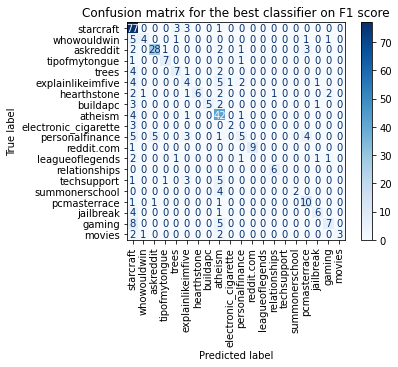

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
LR_OneHot_feature_union = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('one-hot',   CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
        ])
        ),
        ('LR_OneHot', LogisticRegression())
    ])
LR_OneHot_feature_union.fit(train_features,train_labels)
#_=evaluation_summary("LR-OneHot Union Pipeline", LR_OneHot_feature_union.predict(validation_features), validation_labels) 
_=best_f1_score = evaluation_summary("LR-OneHot Union Pipeline", LR_OneHot_feature_union.predict(test_features), test_labels)  
disp = plot_confusion_matrix(LR_OneHot_feature_union, test_features, test_labels,
                                 display_labels=test_labels.unique(),
                                 cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Confusion matrix for the best classifier on F1 score")

LR_TFIDF_feature_union = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize)),  
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize)),  
              ])),
        ])
        ),
        ('LR_TFIDF', LogisticRegression())
    ])
LR_TFIDF_feature_union.fit(train_features,train_labels)
#_ = evaluation_summary("LR_TFIDF Union Pipeline", LR_TFIDF_feature_union.predict(validation_features), validation_labels) 
_ = evaluation_summary("LR_TFIDF Union Pipeline", LR_TFIDF_feature_union.predict(test_features), test_labels) 

In [0]:
from sklearn.svm import SVC

svm_feature_union = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
        ])
        ),
        ('svm', SVC())
    ])
svm_feature_union.fit(train_features,train_labels)
#_=evaluation_summary("SVM Union Pipeline", svm_feature_union.predict(validation_features), validation_labels) 
_=evaluation_summary("SVM Union Pipeline", svm_feature_union.predict(test_features), test_labels) 

Evaluation for: SVM Union Pipeline
Classifier 'SVM Union Pipeline' has Acc=0.416 P=0.142 R=0.162 F1=0.118
                      precision    recall  f1-score   support

           askreddit      0.976     0.350     0.516       234
             atheism      0.000     0.000     0.000         0
            buildapc      0.649     0.774     0.706        31
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.896     0.448     0.597        96
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
       relationships     

In [0]:
from sklearn.ensemble  import RandomForestClassifier

RandomForestClassifier_union = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
        ])
        ),
        ('RandomForestClassifier', RandomForestClassifier())
    ])
RandomForestClassifier_union.fit(train_features,train_labels)
#_=evaluation_summary("RandomForestClassifier Union Pipeline", RandomForestClassifier_union.predict(validation_features), validation_labels) 
_=evaluation_summary("RandomForestClassifier Union Pipeline", RandomForestClassifier_union.predict(test_features), test_labels) 

Evaluation for: RandomForestClassifier Union Pipeline
Classifier 'RandomForestClassifier Union Pipeline' has Acc=0.512 P=0.317 R=0.622 F1=0.338
                      precision    recall  f1-score   support

           askreddit      0.952     0.392     0.556       204
             atheism      0.083     1.000     0.154         1
            buildapc      0.757     0.757     0.757        37
electronic_cigarette      0.889     1.000     0.941         8
   explainlikeimfive      0.000     0.000     0.000         1
              gaming      0.000     0.000     0.000         2
         hearthstone      0.200     1.000     0.333         3
           jailbreak      0.273     1.000     0.429         3
     leagueoflegends      0.854     0.506     0.636        81
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.043     1.000     0.083         1
     personalfinance      0.600     1.000     0.750         6
          reddit.com      0.000     0.000     0.0

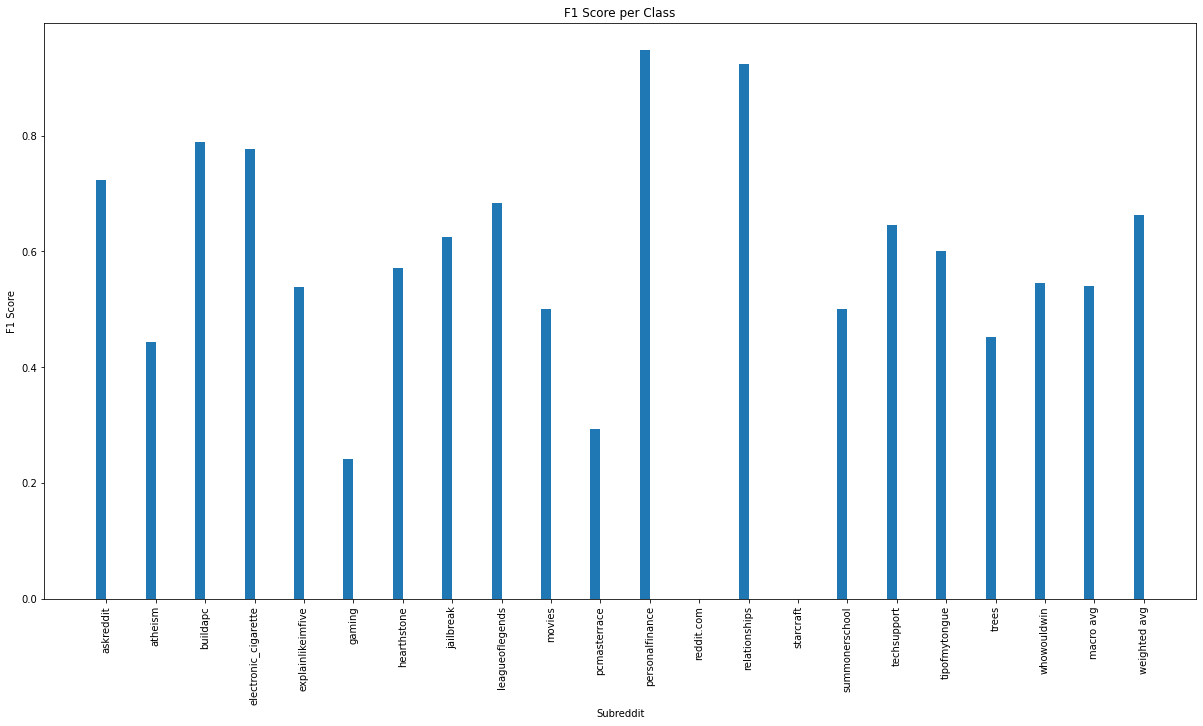

In [0]:
import matplotlib.pyplot as plt
import numpy as np

names = []
scores = []
for key in best_f1_score.keys():
  if key == "accuracy":
    continue
  names.append(key)
  val = best_f1_score[key]['f1-score']
  scores.append(val)
width = 0.2
ind = np.arange(len(names))
fg = plt.figure(figsize=(20,10))
ax = fg.add_axes([0.1,0.1,0.8,0.8])
ax.bar(ind-width/2,scores,width)
ax.set_title("F1 Score per Class")
ax.set_ylabel('F1 Score')
ax.set_xlabel("Subreddit")
ax.set_xticklabels(names)
plt.xticks(ind,rotation=90)
plt.show()

##Q2

Tuning C Value

In [0]:
cmax = 0
best_acc = 0
cvalues = [0.1,1.0,10.0,100.0,1000.0,100000.0]
for cval in cvalues:
  LR_TFIDF_feature_union = Pipeline([
          ('union', FeatureUnion(
            [
              ('title', Pipeline([
                ('selector', ItemSelector(key='title')),
                ('tfidf', TfidfVectorizer()),  
                ])),
              ('author', Pipeline([
                ('selector', ItemSelector(key='author')),
                ('tfidf', TfidfVectorizer()), 
                ])),
              ('body', Pipeline([
                ('selector', ItemSelector(key='body')),
                ('tfidf', TfidfVectorizer()),  
                ])),
          ])
          ),
          ('LR_TFIDF', LogisticRegression(C=cval))
      ])
  LR_TFIDF_feature_union.fit(train_features,train_labels)
  temp_acc = accuracy_score(LR_TFIDF_feature_union.predict(validation_features), validation_labels) 
  if temp_acc > best_acc:
    cmax = cval
    best_acc = temp_acc
print(best_acc,cmax)

0.613013698630137 100000.0


In [0]:
max_max_features = 0
best_acc = 0
max_features_values = [100,1000,5000,10000,20000,]
for mfeatures in max_features_values:
  LR_TFIDF_feature_union = Pipeline([
          ('union', FeatureUnion(
            [
              ('title', Pipeline([
                ('selector', ItemSelector(key='title')),
                ('tfidf', TfidfVectorizer(max_features=mfeatures)),  
                ])),
              ('author', Pipeline([
                ('selector', ItemSelector(key='author')),
                ('tfidf', TfidfVectorizer(max_features=mfeatures)), 
                ])),
              ('body', Pipeline([
                ('selector', ItemSelector(key='body')),
                ('tfidf', TfidfVectorizer(max_features=mfeatures)),  
                ])),
          ])
          ),
          ('LR_TFIDF', LogisticRegression(C=cmax))
      ])
  LR_TFIDF_feature_union.fit(train_features,train_labels)
  temp_acc = accuracy_score(LR_TFIDF_feature_union.predict(validation_features), validation_labels) 
  if temp_acc > best_acc:
    max_max_features = mfeatures
    best_acc = temp_acc
print(best_acc,max_max_features)

0.678082191780822 1000


In [0]:
max_sublinear_tf = 0
best_acc = 0
sublinear_tf_values = [True,False]
for stf in sublinear_tf_values:
  LR_TFIDF_feature_union = Pipeline([
          ('union', FeatureUnion(
            [
              ('title', Pipeline([
                ('selector', ItemSelector(key='title')),
                ('tfidf', TfidfVectorizer(max_features=max_max_features,sublinear_tf=stf)),  
                ])),
              ('author', Pipeline([
                ('selector', ItemSelector(key='author')),
                ('tfidf', TfidfVectorizer(max_features=max_max_features,sublinear_tf=stf)), 
                ])),
              ('body', Pipeline([
                ('selector', ItemSelector(key='body')),
                ('tfidf', TfidfVectorizer(max_features=max_max_features,sublinear_tf=stf)),  
                ])),
          ])
          ),
          ('LR_TFIDF', LogisticRegression(C=cmax))
      ])
  LR_TFIDF_feature_union.fit(train_features,train_labels)
  temp_acc = accuracy_score(LR_TFIDF_feature_union.predict(validation_features), validation_labels) 
  if temp_acc > best_acc:
    max_sublinear_tf = stf
    best_acc = temp_acc
print(best_acc,max_sublinear_tf)

0.678082191780822 True


In [0]:
max_smooth_idf = 0
best_acc = 0
smooth_idf_values = [True,False]
for sidf in smooth_idf_values:
  LR_TFIDF_feature_union = Pipeline([
          ('union', FeatureUnion(
            [
              ('title', Pipeline([
                ('selector', ItemSelector(key='title')),
                ('tfidf', TfidfVectorizer(max_features=max_max_features,sublinear_tf=stf,smooth_idf=sidf)),  
                ])),
              ('author', Pipeline([
                ('selector', ItemSelector(key='author')),
                ('tfidf', TfidfVectorizer(max_features=max_max_features,sublinear_tf=stf,smooth_idf=sidf)), 
                ])),
              ('body', Pipeline([
                ('selector', ItemSelector(key='body')),
                ('tfidf', TfidfVectorizer(max_features=max_max_features,sublinear_tf=stf,smooth_idf=sidf)),  
                ])),
          ])
          ),
          ('LR_TFIDF', LogisticRegression(C=cmax))
      ])
  LR_TFIDF_feature_union.fit(train_features,train_labels)
  temp_acc = accuracy_score(LR_TFIDF_feature_union.predict(validation_features), validation_labels) 
  if temp_acc > best_acc:
    max_smooth_idf = sidf
    best_acc = temp_acc
print(best_acc,max_smooth_idf)

0.678082191780822 True


In [0]:
 LR_TFIDF_feature_union = Pipeline([
          ('union', FeatureUnion(
            [
              ('title', Pipeline([
                ('selector', ItemSelector(key='title')),
                ('tfidf', TfidfVectorizer(max_features=max_max_features,sublinear_tf=stf,smooth_idf=max_smooth_idf)),  
                ])),
              ('author', Pipeline([
                ('selector', ItemSelector(key='author')),
                ('tfidf', TfidfVectorizer(max_features=max_max_features,sublinear_tf=stf,smooth_idf=max_smooth_idf)), 
                ])),
              ('body', Pipeline([
                ('selector', ItemSelector(key='body')),
                ('tfidf', TfidfVectorizer(max_features=max_max_features,sublinear_tf=stf,smooth_idf=max_smooth_idf)),  
                ])),
          ])
          ),
          ('LR_TFIDF', LogisticRegression(C=cmax))
      ])
LR_TFIDF_feature_union.fit(train_features,train_labels)
_ = evaluation_summary("Boosted LR_TFIDF_feature_union", LR_TFIDF_feature_union.predict(test_features), test_labels) 

Evaluation for: Boosted LR_TFIDF_feature_union
Classifier 'Boosted LR_TFIDF_feature_union' has Acc=0.671 P=0.563 R=0.632 F1=0.576
                      precision    recall  f1-score   support

           askreddit      0.917     0.664     0.770       116
             atheism      0.500     0.857     0.632         7
            buildapc      0.865     0.780     0.821        41
electronic_cigarette      0.778     0.875     0.824         8
   explainlikeimfive      0.929     0.929     0.929        14
              gaming      0.353     0.286     0.316        21
         hearthstone      0.400     1.000     0.571         6
           jailbreak      0.727     0.727     0.727        11
     leagueoflegends      0.792     0.717     0.752        53
              movies      0.200     0.500     0.286         2
        pcmasterrace      0.087     0.286     0.133         7
     personalfinance      0.800     1.000     0.889         8
          reddit.com      0.000     0.000     0.000         6
 

## Q3

In [0]:
 
# A function that given an input query item returns the top-k most similar items 
# by their cosine similarity.
def find_similar(query_vector, vd_matrix, top_k = 5):
    cosine_similarities = cosine_similarity(query_vector, vd_matrix).flatten()
    related_doc_indices = cosine_similarities.argsort()[::-1]
    return [(index, cosine_similarities[index]) for index in related_doc_indices][0:top_k]

In [0]:

class MaximumEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, embedding_model):
        self.embedding = embedding_model
        self.dimension = embedding_model.vector_size

    def fit(self, X, y):
        return self
      
    def transform(self, X):  
      # Skip OOV terms. Return 0 if no words are in the vocabulary.
      #print (X)
      return np.array([ 
          np.max([self.embedding[token] for token in doc if token in self.embedding]
                or [np.zeros(self.dimension)], axis=0)
          for doc in X
      ])

In [0]:
import gensim


In [0]:
def similiar_posts_feature(t_features,k=5):
  all_posts_tokenized = t_features.body.apply(tokenize_normalize)
  model = gensim.models.Word2Vec(all_posts_tokenized)
  reddit_vectorizer = MaximumEmbeddingVectorizer(model)
  reddit_post_vector_matrix = reddit_vectorizer.transform(all_posts_tokenized)
  vectorizer = reddit_vectorizer
  matrix = reddit_post_vector_matrix
  results = []
  for tokens in all_posts_tokenized:
    
    transformed = vectorizer.transform([tokens])
    doc = transformed[0:1]

    x = ""
    for index, score in find_similar(doc, matrix, k)[1:]:
      post_contents = t_features.iloc[index]['body'].replace('\n', '')
      x += post_contents
    results.append(x)
  return results
similiar_bodies = similiar_posts_feature(train_features)
train_features['similiar_bodies'] = similiar_bodies
similiar_bodies = similiar_posts_feature(test_features)
test_features['similiar_bodies'] = similiar_bodies
test_features

,title,author,body,similiar_bodies
0,Just a reminder on how much SC2 has evolved th...,"['MeisterKarl', 'smsy', 'vehemus', 'NruJaC']","[""Was watching a VOD from last years DreamHack...","[""Is anyone else suffering this issue? I playe..."
1,Your Favorite Hero Now Has A Healing Factor As...,"[None, 'TheAnti-Monitor', 'iamcatch22', 'blame...","['Basically what the title says.', 'Danny Phan...",['Reposting because I actually have a fairly g...
2,"If you could live anywhere in the world, where...","['Daft-Punk', None, 'AutoModerator', 'Memithez...","['', 'On a beach someplace warm and far away f...",['Jesus travels through time to bring the word...
3,Do you ever get use to exercise?,"['theawe_some', 'DrWallyHayes', 'IGrammarGood'...",['I start running this year. I do it frequentl...,"[""Need to somehow put Windows 8 on my new HDD...."
4,[TOMT] [book] A scary french book for kids,"[None, None, None, None, 'grapesandmilk', None]","['[deleted]', 'Could you possibly provide us a...",['I heard it at my gym but unfortunately don\'...
...,...,...,...,...
360,Reddit Feature Suggestion: Cross posting suppo...,"['magelisk', 'magelisk', 'bageloid', 'squig', ...",['Perhaps I\'m blind but I\'ve never seen this...,['It seems no one is talking about the Void Ra...
361,Interesting conversation with my wife's grandp...,"['jim85541', 'UnclePutin']","[""congrats, it doesn't always go that way. Dam...","[""Okay so let's say you are jungler and you wa..."
362,"Brethren, how many games do you have in your g...","['Taanz', 'FrostyTheHippo', 'Lizzardspawn', 'I...",['39 on steam and roughly 20 on origin. \n\nCo...,"['', 'Being forgotten', ""That's something you ..."
363,[Serious] What are your thoughts on pirating?,"['PotatoStalker', 'AsshatVik', 'mojave_moon', ...","['', 'Helps the industry rather than destroyin...","[""After a long time not touching the genre (Ne..."


In [0]:
 LR_TFIDF_feature_union = Pipeline([
          ('union', FeatureUnion(
            [
              ('title', Pipeline([
                ('selector', ItemSelector(key='title')),
                ('tfidf', TfidfVectorizer(max_features=max_max_features,sublinear_tf=stf,smooth_idf=max_smooth_idf)),  
                ])),
              ('author', Pipeline([
                ('selector', ItemSelector(key='author')),
                ('tfidf', TfidfVectorizer(max_features=max_max_features,sublinear_tf=stf,smooth_idf=max_smooth_idf)), 
                ])),
             ('similiar_bodies', Pipeline([
                ('selector', ItemSelector(key='similiar_bodies')),
                ('tfidf', TfidfVectorizer(max_features=max_max_features,sublinear_tf=stf,smooth_idf=max_smooth_idf)), 
                ])),
              ('body', Pipeline([
                ('selector', ItemSelector(key='body')),
                ('tfidf', TfidfVectorizer(max_features=max_max_features,sublinear_tf=stf,smooth_idf=max_smooth_idf)),  
                ])),
          ])
          ),
          ('LR_TFIDF', LogisticRegression(C=cmax))
      ])
LR_TFIDF_feature_union.fit(train_features,train_labels)
_ = evaluation_summary("Boosted LR_TFIDF_feature_union", LR_TFIDF_feature_union.predict(test_features), test_labels)

Evaluation for: Boosted LR_TFIDF_feature_union
Classifier 'Boosted LR_TFIDF_feature_union' has Acc=0.679 P=0.558 R=0.606 F1=0.563
                      precision    recall  f1-score   support

           askreddit      0.940     0.681     0.790       116
             atheism      0.417     1.000     0.588         5
            buildapc      0.865     0.780     0.821        41
electronic_cigarette      0.889     0.800     0.842        10
   explainlikeimfive      0.929     0.929     0.929        14
              gaming      0.294     0.208     0.244        24
         hearthstone      0.400     1.000     0.571         6
           jailbreak      0.818     0.750     0.783        12
     leagueoflegends      0.812     0.750     0.780        52
              movies      0.000     0.000     0.000         1
        pcmasterrace      0.130     0.375     0.194         8
     personalfinance      0.800     1.000     0.889         8
          reddit.com      0.000     0.000     0.000         3
 

In [0]:
train_features['nbodies'] = train_features.apply(lambda row: str(len(row.body)), axis = 1)
test_features['nbodies'] = test_features.apply(lambda row: str(len(row.body)), axis = 1)


In [0]:
test_features

,title,author,body,similiar_bodies,nbodies
0,Just a reminder on how much SC2 has evolved th...,"['MeisterKarl', 'smsy', 'vehemus', 'NruJaC']","[""Was watching a VOD from last years DreamHack...","[""Is anyone else suffering this issue? I playe...",780
1,Your Favorite Hero Now Has A Healing Factor As...,"[None, 'TheAnti-Monitor', 'iamcatch22', 'blame...","['Basically what the title says.', 'Danny Phan...",['Reposting because I actually have a fairly g...,2915
2,"If you could live anywhere in the world, where...","['Daft-Punk', None, 'AutoModerator', 'Memithez...","['', 'On a beach someplace warm and far away f...",['Jesus travels through time to bring the word...,1648
3,Do you ever get use to exercise?,"['theawe_some', 'DrWallyHayes', 'IGrammarGood'...",['I start running this year. I do it frequentl...,"[""Need to somehow put Windows 8 on my new HDD....",1916
4,[TOMT] [book] A scary french book for kids,"[None, None, None, None, 'grapesandmilk', None]","['[deleted]', 'Could you possibly provide us a...",['I heard it at my gym but unfortunately don\'...,502
...,...,...,...,...,...
360,Reddit Feature Suggestion: Cross posting suppo...,"['magelisk', 'magelisk', 'bageloid', 'squig', ...",['Perhaps I\'m blind but I\'ve never seen this...,['It seems no one is talking about the Void Ra...,6797
361,Interesting conversation with my wife's grandp...,"['jim85541', 'UnclePutin']","[""congrats, it doesn't always go that way. Dam...","[""Okay so let's say you are jungler and you wa...",694
362,"Brethren, how many games do you have in your g...","['Taanz', 'FrostyTheHippo', 'Lizzardspawn', 'I...",['39 on steam and roughly 20 on origin. \n\nCo...,"['', 'Being forgotten', ""That's something you ...",961
363,[Serious] What are your thoughts on pirating?,"['PotatoStalker', 'AsshatVik', 'mojave_moon', ...","['', 'Helps the industry rather than destroyin...","[""After a long time not touching the genre (Ne...",4499


Evaluation for: Boosted LR_TFIDF_feature_union
Classifier 'Boosted LR_TFIDF_feature_union' has Acc=0.668 P=0.536 R=0.597 F1=0.544
                      precision    recall  f1-score   support

           askreddit      0.940     0.617     0.745       128
             atheism      0.500     0.857     0.632         7
            buildapc      0.865     0.780     0.821        41
electronic_cigarette      0.889     0.667     0.762        12
   explainlikeimfive      0.929     0.929     0.929        14
              gaming      0.235     0.222     0.229        18
         hearthstone      0.333     1.000     0.500         5
           jailbreak      0.636     0.778     0.700         9
     leagueoflegends      0.854     0.732     0.788        56
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.087     0.286     0.133         7
     personalfinance      0.800     1.000     0.889         8
          reddit.com      0.000     0.000     0.000         3
 

Text(0.5, 1.0, 'Confusion matrix for the best classifier on F1 score (Neural network)')

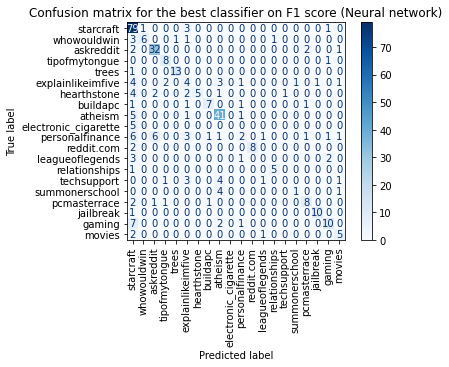

In [0]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import plot_confusion_matrix
LR_TFIDF_feature_union = Pipeline([
          ('union', FeatureUnion(
            [
              ('title', Pipeline([
                ('selector', ItemSelector(key='title')),
                ('tfidf', TfidfVectorizer(max_features=max_max_features,sublinear_tf=stf,smooth_idf=max_smooth_idf)),  
                ])),
              ('author', Pipeline([
                ('selector', ItemSelector(key='author')),
                ('tfidf', TfidfVectorizer(max_features=max_max_features,sublinear_tf=stf,smooth_idf=max_smooth_idf)), 
                ])),
             ('similiar_bodies', Pipeline([
                ('selector', ItemSelector(key='similiar_bodies')),
                ('tfidf', TfidfVectorizer(max_features=max_max_features,sublinear_tf=stf,smooth_idf=max_smooth_idf)), 
                ])),
              ('nbodies', Pipeline([
                ('selector', ItemSelector(key='nbodies')), 
                 ('c', CountVectorizer()),
                ])),
              ('body', Pipeline([
                ('selector', ItemSelector(key='body')),
                ('tfidf', TfidfVectorizer(max_features=max_max_features,sublinear_tf=stf,smooth_idf=max_smooth_idf)),  
                ])),
          ])
          ),
          ('LR_TFIDF', LogisticRegression(C=cmax))
      ])
LR_TFIDF_feature_union.fit(train_features,train_labels)

_ = evaluation_summary("Boosted LR_TFIDF_feature_union", LR_TFIDF_feature_union.predict(test_features), test_labels)

disp = plot_confusion_matrix(LR_TFIDF_feature_union, test_features, test_labels,
                                 display_labels=test_labels.unique(),
                                 cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Confusion matrix for the best classifier on F1 score (Neural network)")

# Part B: Discourse prediction ##

In [0]:
discourse_train = "coursework_discourse_train.json"
discourse_test = "coursework_discourse_test.json"
  
!gsutil cp gs://textasdata/coursework/coursework_discourse_train.json $discourse_train  
!gsutil cp gs://textasdata/coursework/coursework_discourse_test.json  $discourse_test

Copying gs://textasdata/coursework/coursework_discourse_train.json...
/ [1 files][ 60.2 MiB/ 60.2 MiB]                                                
Operation completed over 1 objects/60.2 MiB.                                     
Copying gs://textasdata/coursework/coursework_discourse_test.json...
/ [1 files][ 15.1 MiB/ 15.1 MiB]                                                
Operation completed over 1 objects/15.1 MiB.                                     


In [0]:
# The reddit thread structure is nested with posts in a new content.
# This block reads the file as json and creates a new data frame.
import pandas as pd
import json

def load_posts(file):
  # A temporary variable to store the list of post content.
  posts_tmp = list()

  with open(file) as jsonfile:
    for i, line in enumerate(jsonfile):
     # if (i > 2): break
      thread = json.loads(line)
      for post in thread['posts']:
        # NOTE: This should be changed to use additional features from the post or thread.
        # DO NOT change the labels for the test set.
        posts_tmp.append((thread['subreddit'], thread['title'], thread['url'],
                        post['id'], post.get('author', ""), post.get('body', ""), post.get("majority_link", ""), 
                        post.get('post_depth', 0), post.get('majority_type', ""), # discourse type label 
                        post.get('in_reply_to', "") ))

# Create the posts data frame.  
  labels = ['subreddit', 'title', 'url', 'id', 'author', 'body', 'majority_link', 
          'post_depth', 'discourse_type', 'in_reply_to']
  return pd.DataFrame(posts_tmp, columns=labels)

In [0]:
original_train_posts = load_posts(discourse_train)
# Filter out empty labels
original_train_posts = original_train_posts[original_train_posts['discourse_type'] != ""]
print(original_train_posts.head())
print("Num posts: ", original_train_posts.size)

    subreddit                           title  ... discourse_type in_reply_to
0  worldofpvp  Help me decide my new PvP main  ...       question            
1  worldofpvp  Help me decide my new PvP main  ...         answer   t3_2v0anq
2  worldofpvp  Help me decide my new PvP main  ...         answer   t3_2v0anq
3  worldofpvp  Help me decide my new PvP main  ...         answer   t3_2v0anq
4  worldofpvp  Help me decide my new PvP main  ...         answer   t3_2v0anq

[5 rows x 10 columns]
Num posts:  792670


#### Development / Validation data

For part B it is up to you to split the "original" training data into a new train/validation (development) dataset appropriately. See Lab 4 for an example. 

In [0]:
original_train_posts.head(5)

,subreddit,title,url,id,author,body,majority_link,post_depth,discourse_type,in_reply_to
0,worldofpvp,Help me decide my new PvP main,https://www.reddit.com/r/worldofpvp/comments/2...,t3_2v0anq,TyrickEU,"Hi. \nAs a raider previously, i had no problem...",none,0,question,
1,worldofpvp,Help me decide my new PvP main,https://www.reddit.com/r/worldofpvp/comments/2...,t1_codb2p9,vurt,[deleted] \n ^^^^^^^^^^^^^^^^0.5422 \n > [Wha...,t3_2v0anq,1,answer,t3_2v0anq
2,worldofpvp,Help me decide my new PvP main,https://www.reddit.com/r/worldofpvp/comments/2...,t1_codg0we,OptimusNice,This goes mostly for 3v3 since that seems to b...,t3_2v0anq,1,answer,t3_2v0anq
3,worldofpvp,Help me decide my new PvP main,https://www.reddit.com/r/worldofpvp/comments/2...,t1_coeatsq,,"Rets are in a good position right now, althoug...",t3_2v0anq,1,answer,t3_2v0anq
4,worldofpvp,Help me decide my new PvP main,https://www.reddit.com/r/worldofpvp/comments/2...,t1_codbyit,Rageinjector,Druid are the best pvp healer atm and are grea...,t3_2v0anq,1,answer,t3_2v0anq


In [0]:
# shuffle the data randomly to avoid possible bias.
random_reviews = original_train_posts.sample(frac=1)
# You may change this, but it's set to not be "due big".
review_limit = min(400000, len(random_reviews))
random_reviews = random_reviews.iloc[:review_limit, :]

# 1. Split the data 80/20 train/test
train_split = int(len(random_reviews) * 0.8)
train_posts = random_reviews.iloc[:train_split,:]
validation_posts = random_reviews.iloc[train_split:,:]

### Test data

In [0]:
test_posts = load_posts(discourse_test)
# Filter out empty labels
test_posts = test_posts[test_posts['discourse_type'] != ""]


### Labels

The label for the post we will be predicting is in the discourse_type column.

In [0]:
train_labels = train_posts['discourse_type']
validation_labels = validation_posts['discourse_type']
test_labels = test_posts['discourse_type']

Examine the distribution over labels on the training data.

In [0]:
discourse_counts = original_train_posts['discourse_type'].value_counts()
print(discourse_counts.describe())

top_discourse = discourse_counts.nlargest(20)
print(top_discourse)

count       10.000000
mean      7926.700000
std       9664.321866
min       1266.000000
25%       1671.500000
50%       3235.500000
75%      11919.750000
max      31419.000000
Name: discourse_type, dtype: float64
answer              31419
elaboration         14775
question            13610
appreciation         6849
agreement            3868
disagreement         2603
humor                1787
other                1633
announcement         1457
negativereaction     1266
Name: discourse_type, dtype: int64


## Q4

In [0]:

Q4_Classifier = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('one-hot', TfidfVectorizer(sublinear_tf=True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('one-hot', TfidfVectorizer(sublinear_tf=True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('one-hot', TfidfVectorizer(sublinear_tf=True)),  
              ])),
        ])
        ),
          ('Q4_Classifier', LogisticRegression(C=10))
    ])

In [0]:
Q4_DummyClassifier = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('one-hot', TfidfVectorizer(sublinear_tf=True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('one-hot', TfidfVectorizer(sublinear_tf=True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('one-hot', TfidfVectorizer(sublinear_tf=True)),  
              ])),
        ])
        ),
        ('Q4_DummyClassifier', DummyClassifier(strategy='stratified'))
    ])

In [0]:
Q4_Classifier.fit(train_posts,train_labels)
_=evaluation_summary("Q4_Classifier Union Pipeline", Q4_Classifier.predict(validation_posts), validation_labels) 
_=evaluation_summary("Q4_Classifier Union Pipeline", Q4_Classifier.predict(test_posts), test_labels) 

Evaluation for: Q4_Classifier Union Pipeline
Classifier 'Q4_Classifier Union Pipeline' has Acc=0.539 P=0.336 R=0.448 F1=0.365
                  precision    recall  f1-score   support

       agreement      0.297     0.525     0.380       459
    announcement      0.040     0.077     0.053       142
          answer      0.744     0.607     0.669      7719
    appreciation      0.652     0.719     0.684      1213
    disagreement      0.139     0.306     0.191       255
     elaboration      0.401     0.394     0.398      3035
           humor      0.160     0.463     0.238       134
negativereaction      0.096     0.441     0.157        59
           other      0.347     0.464     0.397       237
        question      0.485     0.487     0.486      2601

        accuracy                          0.539     15854
       macro avg      0.336     0.448     0.365     15854
    weighted avg      0.586     0.539     0.557     15854


Confusion matrix:
 [[ 241    2  294   35   13  161    2   

Text(0.5, 1.0, 'Confusion matrix for the best classifier on F1 score (Neural network)')

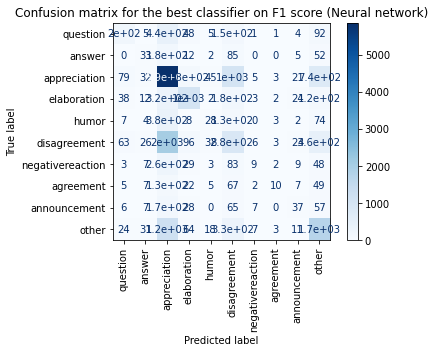

In [0]:
disp = plot_confusion_matrix(Q4_Classifier, test_posts, test_labels,
                                 display_labels=test_labels.unique(),
                                 cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Confusion matrix for the best classifier on F1 score (Neural network)")

In [0]:
Q4_DummyClassifier.fit(train_posts,train_labels)
_=evaluation_summary("DummyClassifier Union Pipeline", Q4_DummyClassifier.predict(validation_posts), validation_labels) 
_=evaluation_summary("DummyClassifier Union Pipeline", Q4_DummyClassifier.predict(test_posts), test_labels) 

Evaluation for: DummyClassifier Union Pipeline
Classifier 'DummyClassifier Union Pipeline' has Acc=0.233 P=0.101 R=0.101 F1=0.101
                  precision    recall  f1-score   support

       agreement      0.055     0.060     0.057       755
    announcement      0.026     0.021     0.023       332
          answer      0.392     0.395     0.393      6258
    appreciation      0.089     0.085     0.087      1397
    disagreement      0.048     0.051     0.050       527
     elaboration      0.182     0.184     0.183      2939
           humor      0.008     0.008     0.008       355
negativereaction      0.015     0.017     0.016       235
           other      0.016     0.015     0.015       334
        question      0.179     0.172     0.175      2722

        accuracy                          0.233     15854
       macro avg      0.101     0.101     0.101     15854
    weighted avg      0.232     0.233     0.232     15854


Confusion matrix:
 [[  45   15  327   67   26  165   1

## Q5

In [0]:
def author_initial(t_feature):
  bin_auth = []
  for index, row in t_feature.iterrows():

    if row['post_depth']==0:
      bin_auth.append(1)
      continue
    temp_auth = row['author']
    if not temp_auth:
      bin_auth.append(0)
      continue

    temp_title = row['title']
    temp_reddit = row['subreddit']
    initial_author = t_feature[t_feature['subreddit']==temp_reddit]
    initial_author = initial_author[initial_author['title']==temp_title]
    initial_author = initial_author[initial_author['post_depth']==0]['author']

    if initial_author.empty:
      bin_auth.append(0)
    else:
      initial_author = initial_author.item()
      if temp_auth == initial_author:
        bin_auth.append(1)
      else:
        bin_auth.append(0)
        
  return bin_auth

In [0]:
bin_auth = author_initial(train_posts)
train_posts['bin_auth'] = bin_auth

In [0]:
train_posts = train_posts.head(10000)
train_labels = train_labels.head(10000)

In [0]:
bin_auth = author_initial(test_posts)
test_posts['bin_auth'] = bin_auth

In [0]:
def similiar_posts_feature(t_features,k=5):
  all_posts_tokenized = t_features.body.apply(tokenize_normalize)
  model = gensim.models.Word2Vec(all_posts_tokenized)
  reddit_vectorizer = MaximumEmbeddingVectorizer(model)
  reddit_post_vector_matrix = reddit_vectorizer.transform(all_posts_tokenized)
  matrix = reddit_post_vector_matrix
  return matrix,model
similiar_bodies,temp_model = similiar_posts_feature(train_posts,3)


In [0]:
temp_sim = []
for x in similiar_bodies:
  if len(np.where(x==max(x))[0])>1:
   temp_sim.append(int(np.where(x==max(x))[0][0]))
  else:
    temp_sim.append(int(np.where(x==max(x))[0]))
train_posts['similiar_bodies'] = temp_sim

In [0]:
test_bodies,temp_model2 = similiar_posts_feature(test_posts,3)
temp_sim = []
for x in test_bodies:
  if len(np.where(x==max(x))[0])>1:
   temp_sim.append(int(np.where(x==max(x))[0][0]))
  else:
    temp_sim.append(int(np.where(x==max(x))[0]))
test_posts['similiar_bodies'] = temp_sim

In [0]:
Q4_Classifier = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('one-hot', TfidfVectorizer(sublinear_tf=True)), 
              ])),
            ('subreddit', Pipeline([
              ('selector', ItemSelector(key='subreddit')),
              ('one-hot', TfidfVectorizer(sublinear_tf=True)), 
              ])),
             ('post_depth', Pipeline([
              ('selector', MySelector(key='post_depth')),
              ])),
            ('bin_auth', Pipeline([
              ('selector', MySelector(key='bin_auth')),
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('one-hot', TfidfVectorizer(sublinear_tf=True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('one-hot', TfidfVectorizer(sublinear_tf=True)),  
              ])),
        ])
        ),
          ('svm', SVC(probability=True))
    ])

In [0]:
Q4_Classifier.fit(train_posts,train_labels)
proba = Q4_Classifier.predict_proba(train_posts)
myproba = []
for x in proba:
  myproba.append(int(np.where(x==max(x))[0]))
train_posts['proba'] = myproba

In [0]:
Q4_Classifier.fit(test_posts,test_labels)
proba = Q4_Classifier.predict_proba(test_posts)
myproba = []
for x in proba:
  myproba.append(int(np.where(x==max(x))[0]))
test_posts['proba'] = myproba

In [0]:
  Q4_Classifier = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('one-hot', TfidfVectorizer(sublinear_tf=True)), 
              ])),
            ('subreddit', Pipeline([
              ('selector2', ItemSelector(key='subreddit')),
              ('one-hot', TfidfVectorizer(sublinear_tf=True)), 
              ])),
             ('post_depth', Pipeline([
              ('selector3', MySelector(key='post_depth')),
              ])),
            ('bin_auth', Pipeline([
            ('selector4', MySelector(key='bin_auth')),
              ])),
          ('proba', Pipeline([
             ('selector5', MySelector(key='proba')),
           ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('one-hot', TfidfVectorizer(sublinear_tf=True)), 
              ])),
           ('vector', Pipeline([
              ('selector', MySelector(key='similiar_bodies')),
              ('one-hot', MaximumEmbeddingVectorizer(temp_model)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('one-hot', TfidfVectorizer(sublinear_tf=True)),  
              ])),
        ])
        ),
          ('Q4_Classifier', LogisticRegression(C=10))
    ])

In [0]:
Q4_Classifier.fit(train_posts,train_labels)
#evaluation_summary("DummyClassifier Union Pipeline", Q4_Classifier.predict(validation_posts), validation_labels) 
_=evaluation_summary("Q5 final Union Pipeline", Q4_Classifier.predict(test_posts), test_labels) 

Evaluation for: Q5 final Union Pipeline
Classifier 'Q5 final Union Pipeline' has Acc=0.734 P=0.491 R=0.560 F1=0.499
                  precision    recall  f1-score   support

       agreement      0.726     0.774     0.749       891
    announcement      0.997     0.929     0.962       392
          answer      0.911     0.820     0.863      8815
    appreciation      0.589     0.782     0.672      1295
    disagreement      0.044     0.224     0.073       125
     elaboration      0.689     0.577     0.628      4334
           humor      0.070     0.330     0.116        97
negativereaction      0.033     0.119     0.051        84
           other      0.082     0.326     0.132        95
        question      0.773     0.719     0.745      3684

        accuracy                          0.734     19812
       macro avg      0.491     0.560     0.499     19812
    weighted avg      0.792     0.734     0.758     19812


Confusion matrix:
 [[ 690    0   95   24    4  113    2    0    0   